In [1]:
import sys, os
import argparse
import time
from types import SimpleNamespace


import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import faiss
import skimage.io as io

from dataset import CocoDataset, EmbedDataset
from utils import weight_init, collater, sec2str
from model import ImageEncoder, CaptionEncoder
from vocab import Vocabulary
from eval import retrieve_i2c, retrieve_c2i

In [14]:
path = "models/vanilla_gru_bs1024"
sorted(os.listdir(path))

['epoch_0001_score_00157.ckpt',
 'epoch_0002_score_00188.ckpt',
 'epoch_0003_score_00226.ckpt',
 'epoch_0004_score_00284.ckpt',
 'epoch_0005_score_00317.ckpt',
 'epoch_0006_score_00384.ckpt',
 'epoch_0007_score_00422.ckpt',
 'epoch_0008_score_00444.ckpt',
 'epoch_0009_score_00498.ckpt',
 'epoch_0010_score_00522.ckpt',
 'epoch_0011_score_00568.ckpt',
 'epoch_0012_score_00600.ckpt',
 'epoch_0013_score_00617.ckpt',
 'epoch_0014_score_00639.ckpt',
 'epoch_0015_score_00682.ckpt',
 'epoch_0016_score_00721.ckpt',
 'epoch_0018_score_00739.ckpt',
 'epoch_0019_score_00763.ckpt',
 'epoch_0020_score_00785.ckpt',
 'epoch_0021_score_00813.ckpt',
 'epoch_0022_score_00826.ckpt',
 'epoch_0023_score_00869.ckpt',
 'epoch_0024_score_00875.ckpt',
 'epoch_0026_score_00881.ckpt',
 'epoch_0027_score_00884.ckpt',
 'epoch_0028_score_00903.ckpt']

In [15]:
def get_args():
    a = {
        "dataset": "coco",
        "checkpoint": os.path.join(path, "epoch_0028_score_00903.ckpt"),   # checkpoint from where to load model
        'root_path': '/groups1/gaa50131/datasets/MSCOCO',
        'vocab_path': 'captions_train2017.txt',
        'cnn_type': "resnet18",
        'rnn_type': "GRU",
        'emb_size': 512,
        'out_size': 512,
        'max_len': 30,
        'n_cpu': 8,
        'imsize': 224, 
        'batch_size': 128  
    }
    
    args = SimpleNamespace(**a)
    
    return args

args = get_args()

In [4]:
# transform if dataset is of images
transform = transforms.Compose([
    transforms.Resize((args.imsize, args.imsize)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
    ])

if args.dataset == 'coco':
    val_dset = CocoDataset(root=args.root_path, imgdir='val2017', jsonfile='annotations/captions_val2017.json', transform=transform, mode='all')
val_loader = DataLoader(val_dset, batch_size=args.batch_size, shuffle=False, num_workers=args.n_cpu, collate_fn=collater)
vocab = Vocabulary(max_len=args.max_len)
vocab.load_vocab(args.vocab_path)

imenc = ImageEncoder(out_size=args.out_size, cnn_type=args.cnn_type)
capenc = CaptionEncoder(vocab_size=len(vocab), emb_size=args.emb_size, out_size=args.out_size, rnn_type=args.rnn_type, padidx=vocab.padidx)
device = torch.device("cuda" if torch.cuda.is_available() and not args.no_cuda else "cpu")

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
building vocabulary...
done building vocabulary, minimum frequency is 5 times
# of words in vocab: 10210 | elapsed: 31s


In [16]:
assert args.checkpoint is not None
print("loading model checkpoint from {}".format(args.checkpoint))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ckpt = torch.load(args.checkpoint, map_location=device)
imenc.load_state_dict(ckpt["encoder_state"])
capenc.load_state_dict(ckpt["decoder_state"])

begin = time.time()
print("creating database")
dset = EmbedDataset(val_loader, imenc, capenc, vocab, args)
print("database created | {}".format(sec2str(time.time()-begin)))

loading model checkpoint from models/vanilla_gru_bs1024/epoch_0028_score_00903.ckpt
creating database
database created | elapsed: 33s


--------------------------------------------------


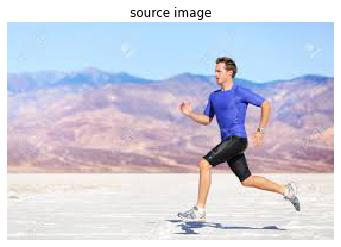

# captions: 25000, dimension: 512
retrieval time elapsed: 00s
--------------------------------------------------
10 nearest neighbors of image:
A black and white image of a formal occasion. 
The bride and groom stand at the alter near a priest. 
The street is blocked by a truck and a crane.
A tan horse with a blond mane inside of a coral.
A water hydrant is that frozen with nothing on it. 
A toddler standing with a brush in her mouth.
A zebra with a striped face and pure white neck and mane.
A huge dragon kite flown with a steeple in the background.
A horse and carriage with people riding in it.
A tourist unfolds an umbrella near ancient ruins.
--------------------------------------------------


In [32]:
%matplotlib inline
retrieve_i2c(dset, val_dset, "samples/sample1.jpg", imenc, transform, k=10)

--------------------------------------------------
source caption: 'the elephant looks this way'
# images: 5000, dimension: 512
retrieval time elapsed: 00s
--------------------------------------------------
10 nearest neighbors of 'the elephant looks this way'


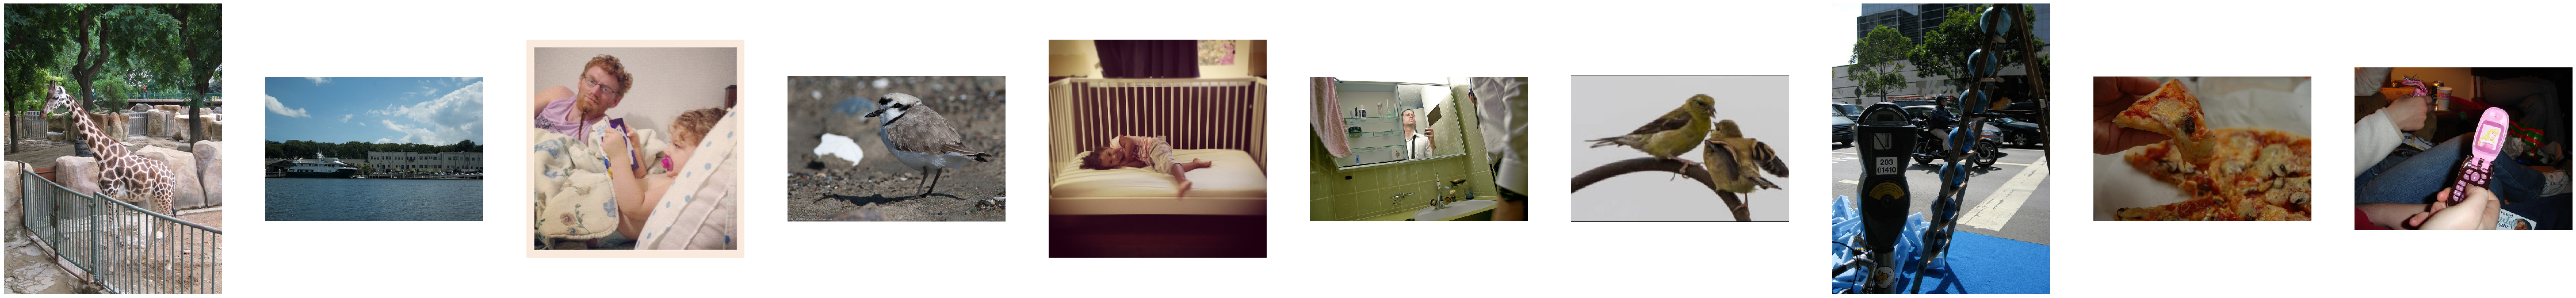

--------------------------------------------------


In [34]:
%matplotlib inline
caption = "the elephant looks this way"
retrieve_c2i(dset, val_dset, caption, capenc, vocab, k=10)